<h2>Spam Filter with a Soft Margin Support Vector Machine, Ridge Regression, and Logistic Regression.</h2>

<p>
Building a spam filter using a bag of words approach is a binary classification problem in a high dimensional feature space. This means data is likely linearly seperable, and if it is not then there is a seperating hyperplane that will make predictions with high accuracy. To find this seperating hyperlane, we can minimize the following loss functions using the adagrad gradient descent algorithm:
</p>




<h3>Loss Functions</h3>

<ol>
    <li> Ridge Regression: ($y_i\in\{+1,-1\}$); ${\cal L}(w)= \frac{1}{n}\sum_{i=1}^n (w^\top x_i-y_i)^2+\lambda \|w\|_2^2$ 
    </li>
    <li> Hinge Loss (SVM): ($y_i\in\{+1,-1\}$);  ${\cal L}(w)=\sum_{i=1}^n \max \left(1-y_i(w^\top x_i+b),0\right)+\lambda \|w\|_2^2$ </li>
    <li> Logistic Regression: ($y_i\in\{+1,-1\}$);  ${\cal L}(w)=\sum_{i=1}^n \log(1+\exp{(-y_i w^\top x_i)})$ </li>
    
</ol>  

<h3>Feature Extraction</h3>
<p>We can take a bag of words approach, hashing each word to the index of an array and adding a count of one if the word is present </p>


In [6]:
import numpy as np
import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import sys
from scipy.io import loadmat
import time

%matplotlib inline

In [7]:
# tokenize the email and hashes the symbols into a vector
def extractfeaturesnaive(path, B):
    with open(path, 'r') as femail:
        # initialize all-zeros feature vector
        v = np.zeros(B)
        email = femail.read()
        # breaks for non-ascii characters
        tokens = email.split()
        for token in tokens:
            v[hash(token) % B] = 1
    return v

def loadspamdata(extractfeatures, B=6000, path="SMSSpamCollection"):
    '''
    INPUT:
    extractfeatures : function to extract features
    B               : dimensionality of feature space
    path            : the path of folder to be processed
    
    OUTPUT:
    X, Y
    '''
    
    with open(path, 'r') as f:
        allemails = [x for x in f.read().split('\n') if ' ' in x]
    
    xs = np.zeros((len(allemails), B))
    ys = np.zeros(len(allemails))
    for i, line in enumerate(allemails):
        label, filename = line.split('	')
        
        # make labels +1 for "spam" and -1 for "ham"
        ys[i] = (label == 'spam') * 2 - 1
        xs[i, :] = extractfeatures(path, B)
    print('Loaded %d input emails.' % len(ys))
    return xs, ys

X,Y = loadspamdata(extractfeaturesnaive)
X.shape

Loaded 5535 input emails.


(5535, 6000)

Split data into training and validation sets. 

In [8]:
# Split data into training and validation
n, d = X.shape
cutoff = int(np.ceil(0.8 * n))
# indices of training samples
xTr = X[:cutoff,:]
yTr = Y[:cutoff]
# indices of testing samples
xTv = X[cutoff:,:]
yTv = Y[cutoff:]

<h3>Ridge Regression </h3>

<p> ${\cal L}(w)=\frac{1}{n}\sum_{i=1}^n (w^\top x_i-y_i)^2+\lambda \|w\|_2^2$; ($y_i\in\{+1,-1\}$)  </p>

In [10]:
def ridge(w,xTr,yTr,lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    
    n, d = xTr.shape
    #loss
    #dotted = np.dot(xTr,w)
    #subbed = dotted - yTr
    #sqrd   = np.square(subbed)
    #summed = np.sum(sqrd)/n
    #dub    = lmbda*np.dot(w,w)
    
    #gradient
    dotted = np.dot(xTr,w)
    subbed = dotted - yTr
    summed = 2*(np.dot(subbed.T,xTr)/n + lmbda*w)
    

    return (lmbda*np.dot(w,w)+ np.sum(np.square(np.dot(xTr,w)-yTr ))/n), summed


<h3> Gradient Verification </h3>

<p>An  alternative to  deriving the gradient analytically is to estimate it numerically. This is very slow, so it is only used to check for correctness. The function also plots an image of the gradient values (blue) and their estimates (red). If everything is correct, these two should be right on top of each other. The norm difference between the numerical and analytical solution should be very small (smaller than $10^{-8}$). </p>

<p>
NOTE: This verification is only valid if the loss function was implemented correctly, since the gradient corresponds to the loss. 
</p>


The norm ratio is 0.0000000102.


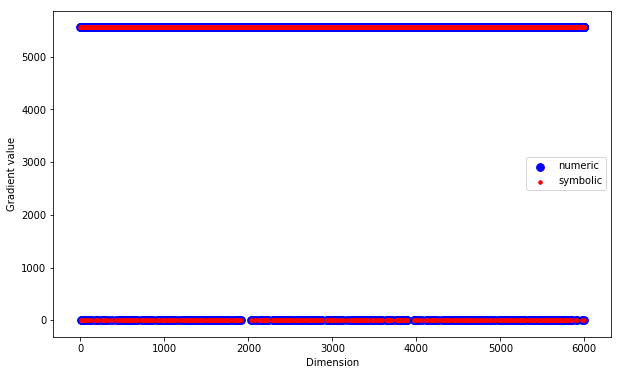

In [11]:
def numericalgradient(fun,w,e):
    # get dimensionality
    d = len(w)
    # initialize numerical derivative
    dh = np.zeros(d)
    # go through dimensions
    for i in range(d):
        # copy the weight vector
        nw = w.copy()
        # perturb dimension i
        nw[i] += e
        # compute loss
        l1, temp = fun(nw)
        # perturb dimension i again
        nw[i] -= 2*e
        # compute loss
        l2, temp = fun(nw)
        # the gradient is the slope of the loss
        dh[i] = (l1 - l2) / (2*e)
    return dh

def checkgrad(fun,w,e):
    # evaluate symbolic gradient from fun()
    loss,dy = fun(w)
    # estimate gradient numerically from fun()
    dh = numericalgradient(fun,w,e)
    
    # ii = dy.argsort()
    ii = np.array([i for i in range(len(dy))])
    
    plt.figure(figsize=(10,6))
    plt.scatter([i for i in range(len(dy))], dh[ii], c='b', marker='o', s=60)
    plt.scatter([i for i in range(len(dy))], dy[ii], c='r', marker='.', s=50)
    plt.xlabel('Dimension')
    plt.ylabel('Gradient value')
    plt.legend(["numeric","symbolic"])
    
    # return the norm of the difference scaled by the norm of the sum
    return np.linalg.norm(dh - dy) / np.linalg.norm(dh + dy)

# set lmbda (λ) arbitrarily
lmbda = 0.1
# dimensionality of the input
_, d = xTr.shape
# evaluate loss on random vector
w = np.random.rand(d)

ratio = checkgrad(lambda weight: ridge(weight,xTr,yTr,lmbda),w,1e-05)
print("The norm ratio is %.10f." % ratio)

<h3>Adagrad Gradient Descent </h3>

              

In [14]:
def adagrad(func,w,alpha,maxiter,eps,delta=1e-02):
    """
    INPUT:
    func    : function to minimize
              (loss, gradient = func(w))
    w       : d dimensional initial weight vector 
    alpha   : initial gradient descent stepsize (scalar)
    maxiter : maximum amount of iterations (scalar)
    eps     : epsilon value
    delta   : if norm(gradient)<delta, it quits (scalar)
    
    OUTPUTS:
     
    w      : d dimensional final weight vector
    losses : vector containing loss at each iteration
    """
    
    #get subarray if we terminate early 
    losses = np.zeros(maxiter)
    zd     = np.zeros(w.size)

    for i in range(0,maxiter):
        loss,grad = func(w)
        losses[i]=loss
        zd = zd + np.square(grad)
        w  = w  - alpha*grad/(np.sqrt(zd+eps))
        if (np.linalg.norm(grad)<delta ):
            return w,losses[:i+1]
        
        
            
    return w,losses


<h3>Adagrad Convergence Visual</h3>
<p>We can visualize adagrad's path to convergence to ensure that the algorithm is behaving as expected </p>

Final loss: 45.601493


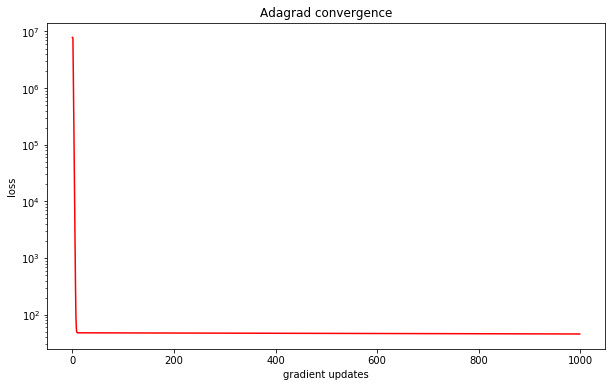

In [15]:
_, d = xTr.shape
eps = 1e-06
w, losses = adagrad(lambda weight: ridge(weight, xTr, yTr, lmbda), np.random.rand(d), 1, 1000, eps)

plt.figure(figsize=(10,6))
plt.semilogy(losses, c='r', linestyle='-')
plt.xlabel("gradient updates")
plt.ylabel("loss")
plt.title("Adagrad convergence")
print("Final loss: %f" % losses[-1])

<h3>Final Evaluation </h3>

<p>After this we can check training and validation accuracy by running the cell below.</p>

In [16]:
def class_unbiased(xi,w):
    val=np.dot(xi,w)
    if val>0:
        return 1
    elif val<0:
        return -1
    else:
        return 0
        
def linclassify(w,xTr):
    ## fill in your code here
    w = w.reshape(-1)
    ## fill in code here
    return np.fromiter((class_unbiased(xi,w) for xi in xTr),int, count=xTr.shape[0])
    
    

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

Training accuracy 86.40%
Validation accuracy 86.90%



<p>The same follows for our other two other loss functions, <code>hinge</code> and <code>logistic</code>. </p>

<h3>Hinge Loss</h3>
<p> ${\cal L}(w)=\sum_{i=1}^n \max \left(1-y_i(w^\top x_i+b),0\right)+\lambda \|w\|_2^2$ ; ($y_i\in\{+1,-1\}$)</p>

In [17]:
def hinge(w,xTr,yTr,lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d       = xTr.shape
    
    regulizer  = lmbda*np.dot(w,w)
    pre_summed = np.maximum(1-yTr*np.dot(xTr,w),0)
    
    loss       = np.sum(pre_summed) + regulizer 
    reg_grad   = 2*lmbda*w
    
    
    the_bool = yTr*np.dot(xTr,w)
    xTr_copy = np.copy(xTr)
    
    xTr_copy[the_bool>=1]=0
    
    grad = np.dot(-yTr,xTr_copy)+ reg_grad
    

    return loss,grad
 

<h3> Hinge Loss Verification </h3>

In [ ]:
# Gradient sanity check
lmbda = 0.1
_, d = xTr.shape
w = np.random.rand(d)
ratio = checkgrad(lambda weight: hinge(weight,xTr,yTr,lmbda),w,1e-05)
print("The norm ratio is %.10f." % ratio)

In [18]:
lmbda = 0.1
w, losses = adagrad(lambda weight: hinge(weight,xTr,yTr,lmbda), np.random.rand(d), 1, 1000, 1e-06)

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

Training accuracy 86.40%
Validation accuracy 86.90%



<h3>  Logistic Regression:  </h3>
<p> ${\cal L}(w)=\sum_{i=1}^n \log(1+\exp{(-y_i w^\top x_i)})$ ; ($y_i\in\{+1,-1\}$)  </p>

In [14]:
def logistic(w,xTr,yTr):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    
    # w_dot_xi = np.dot(xTr,w)
    e     = np.exp(np.dot(xTr,w) * -yTr)
    #loss  = np.sum(np.log(1+e))
    loss   = np.sum(np.log(1 + np.exp(np.dot(xTr,w) * -yTr)))

    pre = -yTr*e/(1+e)
    grad = np.dot(xTr.T,pre)
    
    
    
    return loss, grad


<h3> Logistic Regression Verification</h3>


In [ ]:
# Gradient sanity check
_, d = xTr.shape
w = np.random.rand(d)
ratio = checkgrad(lambda weight: logistic(weight,xTr,yTr),w,1e-05)
print("The norm ratio is %.10f." % ratio)

In [ ]:
w, losses = adagrad(lambda weight: logistic(weight, xTr, yTr), np.random.rand(d), 1, 1000, 1e-06)

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))